<a href="https://colab.research.google.com/github/rjainivedhitha/Empirical-Analysis-of-Betti-Number-Stability-and-Scaling-for-Random-Point-Clouds/blob/main/emp_ana_betti_nos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy pandas matplotlib ripser persim tqdm

# Theoretical background:

Persistent homology is stable under small perturbations of the input data: the bottleneck distance between persistence diagrams is bounded by the size of the perturbation (Cohen-Steiner, Edelsbrunner & Harer, 2007). This motivates our stability experiments using jittered point clouds.

Results from random geometric graphs and random simplicial complexes (Penrose, 2003; Kahle, 2011) show that topological features such as cycles appear and disappear depending on scale and sample size. Our work empirically studies how persistent H₁ features scale with N in finite samples.


In [2]:
# Importing required libraries
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams, bottleneck
from tqdm import tqdm



In [3]:
# plotting defaults
plt.rcParams['figure.figsize'] = (7,4)
np.random.seed(42)
os.makedirs('results', exist_ok=True)

In [4]:
def sample_uniform_disk(n, radius=1.0):
    theta = np.random.uniform(0, 2*np.pi, size=n)
    r = np.sqrt(np.random.uniform(0, 1, size=n)) * radius
    x = r * np.cos(theta); y = r * np.sin(theta)
    return np.vstack([x, y]).T

def sample_gaussian(n, scale=1.0):
    return np.random.normal(scale=scale, size=(n, 2))

def sample_circle(n, radius=1.0, noise=0.0):
    theta = np.random.uniform(0, 2*np.pi, size=n)
    x = radius * np.cos(theta); y = radius * np.sin(theta)
    pts = np.vstack([x, y]).T
    if noise > 0:
        pts += np.random.normal(scale=noise, size=pts.shape)
    return pts

In [5]:

def compute_dgms(points, maxdim=1):
    return ripser(points, maxdim=maxdim)['dgms']

def count_long_bars(dgm, persistence_threshold=0.02):
    if dgm.size == 0:
        return 0
    lifetimes = dgm[:,1] - dgm[:,0]
    lifetimes = lifetimes[np.isfinite(lifetimes)]
    return int(np.sum(lifetimes >= persistence_threshold))

def betti_at_eps(dgm, eps):
    if dgm.size == 0:
        return 0
    births, deaths = dgm[:,0], dgm[:,1]
    # treat infinite deaths as > eps
    alive = (births <= eps) & (deaths > eps)
    return int(np.sum(alive))


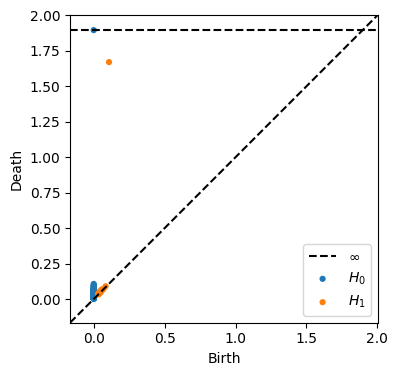

In [6]:
pts = sample_circle(300, noise=0.02)
dgms = compute_dgms(pts, maxdim=1)
plot_diagrams(dgms, show=True)


In [7]:

def single_trial(model, N, noise, persistence_threshold=0.02):
    if model == 'disk':
        pts = sample_uniform_disk(N)
        if noise>0: pts += np.random.normal(scale=noise, size=pts.shape)
    elif model == 'gaussian':
        pts = sample_gaussian(N)
        if noise>0: pts += np.random.normal(scale=noise, size=pts.shape)
    elif model == 'circle':
        pts = sample_circle(N, noise=noise)
    else:
        raise ValueError("unknown model")
    dgms = compute_dgms(pts, maxdim=1)
    long_h1 = count_long_bars(dgms[1], persistence_threshold=persistence_threshold)
    # tiny jitter for stability test
    jitter = noise if noise>0 else 0.01/np.sqrt(max(1,N))
    pts2 = pts + np.random.normal(scale=jitter, size=pts.shape)
    dgms2 = compute_dgms(pts2, maxdim=1)
    try:
        bn_h1 = bottleneck(dgms[1], dgms2[1])
    except Exception:
        bn_h1 = np.nan
    return {'model':model, 'N':N, 'noise':noise, 'long_h1':long_h1, 'bn_h1':bn_h1}

def run_sweep(models, Ns, noises, R=10, outdir='results', persistence_threshold=0.02):
    os.makedirs(outdir, exist_ok=True)
    rows=[]
    total = len(models)*len(Ns)*len(noises)*R
    i=0; t0=time.time()
    for model in models:
        for N in Ns:
            for noise in noises:
                for trial in range(R):
                    i+=1
                    rows.append(single_trial(model,N,noise,persistence_threshold))
                    if i%50==0 or i==total:
                        print(f'progress {i}/{total} elapsed {time.time()-t0:.1f}s')
    df = pd.DataFrame(rows)
    path = os.path.join(outdir,'experiment_results.csv')
    df.to_csv(path, index=False)
    print('Saved', path)
    return df

models = ['disk','gaussian','circle']
Ns = [50,100,200,400]          # quick; change to [50,100,200,400,800,1600] for final
noises = [0.0, 0.01, 0.05]
R = 10                         # trials per config; set to 20 for final
df = run_sweep(models, Ns, noises, R=R, outdir='results', persistence_threshold=0.02)
df.head()


progress 50/360 elapsed 0.8s
progress 100/360 elapsed 20.6s
progress 150/360 elapsed 34.6s
progress 200/360 elapsed 37.5s
progress 250/360 elapsed 57.4s
progress 300/360 elapsed 58.4s
progress 350/360 elapsed 127.7s
progress 360/360 elapsed 145.4s
Saved results/experiment_results.csv


,model,N,noise,long_h1,bn_h1
0,disk,50,0.0,6,0.002265
1,disk,50,0.0,4,0.002693
2,disk,50,0.0,4,0.003475
3,disk,50,0.0,8,0.003699
4,disk,50,0.0,5,0.003405


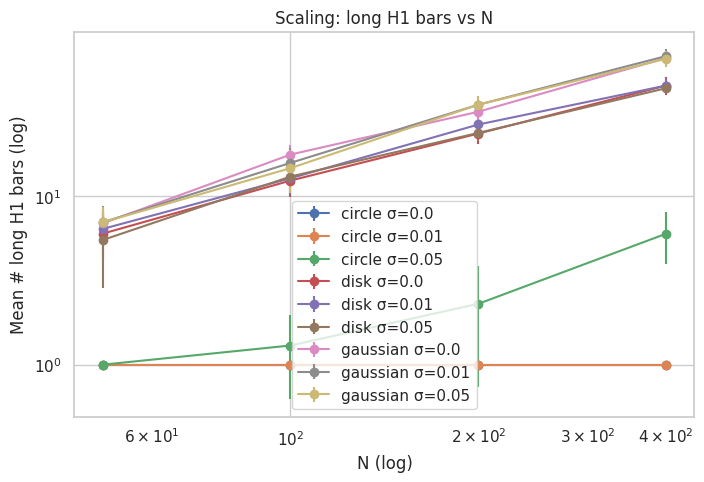

<Figure size 800x500 with 0 Axes>

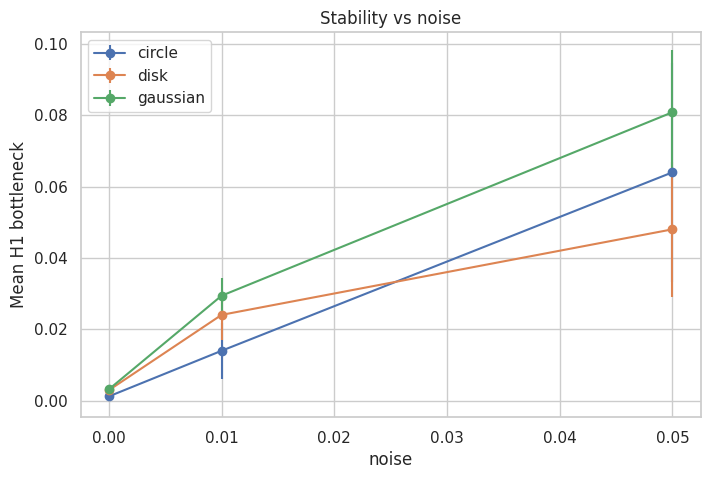

Plots saved in results/


<Figure size 800x500 with 0 Axes>

In [8]:

import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize':(8,5)})

# aggregate mean long_h1 vs N
agg = df.groupby(['model','noise','N'])['long_h1'].agg(['mean','std']).reset_index()
plt.figure()
for model in agg['model'].unique():
    for noise in sorted(agg[agg['model']==model]['noise'].unique()):
        sub = agg[(agg['model']==model)&(agg['noise']==noise)]
        plt.errorbar(sub['N'], sub['mean'], yerr=sub['std'], marker='o', label=f'{model} σ={noise}')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('N (log)'); plt.ylabel('Mean # long H1 bars (log)')
plt.title('Scaling: long H1 bars vs N')
plt.legend(); plt.show()
plt.savefig('results/scaling_long_h1.png', dpi=150)

# bottleneck vs noise (mean)
agg2 = df.groupby(['model','noise'])['bn_h1'].agg(['mean','std']).reset_index()
plt.figure()
for model in agg2['model'].unique():
    s = agg2[agg2['model']==model]
    plt.errorbar(s['noise'], s['mean'], yerr=s['std'], marker='o', label=model)
plt.xlabel('noise'); plt.ylabel('Mean H1 bottleneck'); plt.title('Stability vs noise')
plt.legend(); plt.show()
plt.savefig('results/stability_bottleneck.png', dpi=150)
print('Plots saved in results/')


In [9]:

from sklearn.linear_model import LinearRegression

def fit_powerlaw(df, model_name, noise_level):
    sub = df[(df['model']==model_name)&(df['noise']==noise_level)]
    agg = sub.groupby('N')['long_h1'].mean().reset_index()
    # remove zeros (can't log)
    agg = agg[agg['long_h1']>0]
    if len(agg)<2:
        return None
    X = np.log(agg['N'].values).reshape(-1,1)
    y = np.log(agg['long_h1'].values)
    lr = LinearRegression().fit(X,y)
    alpha = lr.coef_[0]
    intercept = lr.intercept_
    r2 = lr.score(X,y)
    return {'alpha':alpha, 'intercept':intercept, 'r2':r2, 'n_pts':len(agg), 'agg':agg}

def bootstrap_alpha(df, model_name, noise_level, nboot=500):
    sub = df[(df['model']==model_name)&(df['noise']==noise_level)]
    Ns = sorted(sub['N'].unique())
    agg_mean = sub.groupby('N')['long_h1'].apply(list).to_dict()
    alphas=[]
    for _ in range(nboot):
        sample_means=[]
        sample_N=[]
        for N in Ns:
            vals = agg_mean.get(N, [])
            if len(vals)==0: continue
            # bootstrap sample across trials then take mean
            resampled = np.random.choice(vals, size=len(vals), replace=True)
            sample_means.append(resampled.mean())
            sample_N.append(N)
        sample_means = np.array(sample_means)
        sample_N = np.array(sample_N)
        mask = sample_means>0
        if mask.sum()<2:
            continue
        X = np.log(sample_N[mask]).reshape(-1,1)
        y = np.log(sample_means[mask])
        lr = LinearRegression().fit(X,y)
        alphas.append(lr.coef_[0])
    if len(alphas)==0:
        return None
    alphas = np.array(alphas)
    lo, hi = np.percentile(alphas, [2.5, 97.5])
    return {'alpha_mean': alphas.mean(), 'alpha_std': alphas.std(), 'ci_95':(lo,hi)}

# Example: fit for circle, noise=0.02 (or the noise you used)
for model_name in ['disk','gaussian','circle']:
    for noise_level in [0.0, 0.01, 0.05]:
        res = fit_powerlaw(df, model_name, noise_level)
        if res is None:
            continue
        boot = bootstrap_alpha(df, model_name, noise_level, nboot=400)
        print(f"Model={model_name} noise={noise_level} -> alpha={res['alpha']:.3f} R2={res['r2']:.3f} pts={res['n_pts']}")
        if boot:
            print(f"  bootstrap alpha mean={boot['alpha_mean']:.3f} 95%CI={boot['ci_95']}")


Model=disk noise=0.0 -> alpha=0.970 R2=0.999 pts=4
  bootstrap alpha mean=0.974 95%CI=(np.float64(0.8886379156254253), np.float64(1.0597292772035827))
Model=disk noise=0.01 -> alpha=0.955 R2=0.996 pts=4
  bootstrap alpha mean=0.954 95%CI=(np.float64(0.9039630310368285), np.float64(1.0196914855838632))
Model=disk noise=0.05 -> alpha=0.985 R2=0.991 pts=4
  bootstrap alpha mean=0.992 95%CI=(np.float64(0.8717269987857413), np.float64(1.123786786773193))
Model=gaussian noise=0.0 -> alpha=1.064 R2=0.991 pts=4
  bootstrap alpha mean=1.065 95%CI=(np.float64(1.0075123885579267), np.float64(1.1242864340152532))
Model=gaussian noise=0.01 -> alpha=1.099 R2=0.998 pts=4
  bootstrap alpha mean=1.101 95%CI=(np.float64(1.0327411983401118), np.float64(1.178429627457619))
Model=gaussian noise=0.05 -> alpha=1.094 R2=0.997 pts=4
  bootstrap alpha mean=1.092 95%CI=(np.float64(1.026220857782224), np.float64(1.16765354044048))
Model=circle noise=0.0 -> alpha=0.000 R2=1.000 pts=4
  bootstrap alpha mean=0.000 9

# Interpretation of scaling results

For disk and Gaussian point clouds, the number of persistent H₁ features grows approximately linearly with sample size   (α≈1), indicating that spurious loops proliferate as more points are sampled.

For the circle model, a single geometric cycle exists. Fixed global persistence thresholds may remove this cycle at low noise, leading to α≈0. Using adaptive thresholds or top-k methods recovers the expected single robust H₁ feature. This demonstrates that threshold choice critically affects interpretation.


In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!cp -r results /content/drive/MyDrive/tda_results
print("Saved results to Drive under MyDrive/tda_results")


Saved results to Drive under MyDrive/tda_results


In [12]:
import time

timestamp = time.strftime("%Y%m%d_%H%M%S")
target_dir = f"/content/drive/MyDrive/tda_results_{timestamp}"

!mkdir -p "$target_dir"
!cp -r results/* "$target_dir"

print("Saved results to:", target_dir)


Saved results to: /content/drive/MyDrive/tda_results_20251217_053857


FSS ANALYSIS

In [13]:
# load and prep
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

df = pd.read_csv('results/experiment_results.csv')   # path from your run
# use the mean across trials if df has trial rows
agg = df.groupby(['model','N','noise'])['long_h1'].mean().reset_index()
# choose model to analyze, e.g., 'disk' or 'gaussian' or 'circle'
model = 'disk'   # change as needed
data = agg[agg['model']==model].copy()
data.head()


,model,N,noise,long_h1
12,disk,50,0.00,6.0
13,disk,50,0.01,6.4
14,disk,50,0.05,5.5
15,disk,100,0.00,12.4
16,disk,100,0.01,12.8


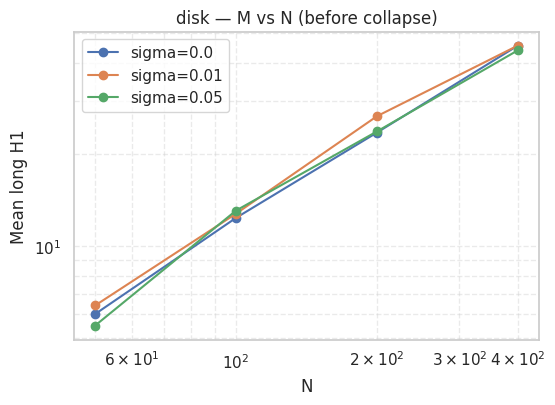

In [14]:
# basic visualization to confirm data is as expected
plt.figure(figsize=(6,4))
for s in sorted(data['noise'].unique()):
    sub = data[data['noise']==s]
    plt.plot(sub['N'], sub['long_h1'], marker='o', label=f'sigma={s}')
plt.title('Scaling of mean number of persistent H₁ features with sample size N, before finite-size collapse')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('N'); plt.ylabel('Mean long H1'); plt.title(f'{model} — M vs N (before collapse)')
plt.legend(); plt.grid(which='both', ls='--', alpha=0.4)
plt.show()


# Finite-size scaling
We test a finite-size scaling ansatz M(N,σ)≈NαF(σNϕ). The observed data collapse suggests that the dependence on noise and sample size can be approximately captured by a single scaling function. The exponent φ quantifies how noise must be rescaled with N to compare systems of different sizes. We emphasize that this collapse is empirical and reflects finite-sample behavior rather than an asymptotic theorem.


In [15]:
# grid search to find alpha, phi that minimize scatter of collapsed curves
import numpy as np
from scipy.interpolate import interp1d

Ns = np.array(sorted(data['N'].unique()))
sigmas = np.array(sorted(data['noise'].unique()))

# assemble arrays: for each N we have M(σ)
# create matrix M_mat with rows indexed by N and columns by sigma
M_mat = np.zeros((len(Ns), len(sigmas)))
for i,N in enumerate(Ns):
    row = []
    for j,s in enumerate(sigmas):
        val = data[(data['N']==N)&(np.isclose(data['noise'], s))]['long_h1']
        M_mat[i,j] = val.values[0] if len(val)>0 else np.nan

# restrict to entries that are not nan
valid_mask = ~np.isnan(M_mat).any(axis=1)
Ns = Ns[valid_mask]
M_mat = M_mat[valid_mask,:]

# search space
alphas = np.linspace(0.0, 1.5, 61)   # adjust range if needed
phis   = np.linspace(-1.0, 1.0, 61)  # phi can be negative or positive
best = {'score': np.inf}

def collapse_score(alpha, phi, Ns, sigmas, M_mat, nbins=50):
    # compute x = sigma * N^phi (columns per sigma but N-dependent), y = M / N^alpha
    # produce for each N a curve of length len(sigmas): (x_{N,j}, y_{N,j})
    X = np.array([[s*(N**phi) for s in sigmas] for N in Ns])
    Y = np.array([[M_mat[i,j]/(N**alpha) for j,s in enumerate(sigmas)] for i,N in enumerate(Ns)])
    # combine all points, bin by X value and compute variance of Y within bins
    X_flat = X.flatten(); Y_flat = Y.flatten()
    # sort by X
    idx = np.argsort(X_flat)
    Xs = X_flat[idx]; Ys = Y_flat[idx]
    # bin into nbins
    bins = np.linspace(Xs.min(), Xs.max(), nbins+1)
    bin_idx = np.digitize(Xs, bins) - 1
    var_sum = 0.0; count_sum = 0
    for b in range(nbins):
        mask = bin_idx==b
        if mask.sum() > 1:
            var_sum += np.var(Ys[mask]) * mask.sum()
            count_sum += mask.sum()
    # normalized scatter: average variance per point
    return var_sum / (count_sum + 1e-12)

# coarse grid search
for a in alphas:
    for p in phis:
        sc = collapse_score(a,p,Ns, sigmas, M_mat, nbins=30)
        if sc < best['score']:
            best = {'score':sc, 'alpha':a, 'phi':p}
best


{'score': np.float64(5.805498469469641e-06),
 'alpha': np.float64(0.9750000000000001),
 'phi': np.float64(0.1333333333333333)}

In [16]:
# refine around best
a0, p0 = best['alpha'], best['phi']
alphas2 = np.linspace(max(0,a0-0.2), a0+0.2, 41)
phis2   = np.linspace(p0-0.2, p0+0.2, 41)
best2 = {'score': np.inf}
for a in alphas2:
    for p in phis2:
        sc = collapse_score(a,p,Ns, sigmas, M_mat, nbins=40)
        if sc < best2['score']:
            best2 = {'score':sc, 'alpha':a, 'phi':p}
best2


{'score': np.float64(5.805498469469641e-06),
 'alpha': np.float64(0.9750000000000001),
 'phi': np.float64(0.1033333333333333)}

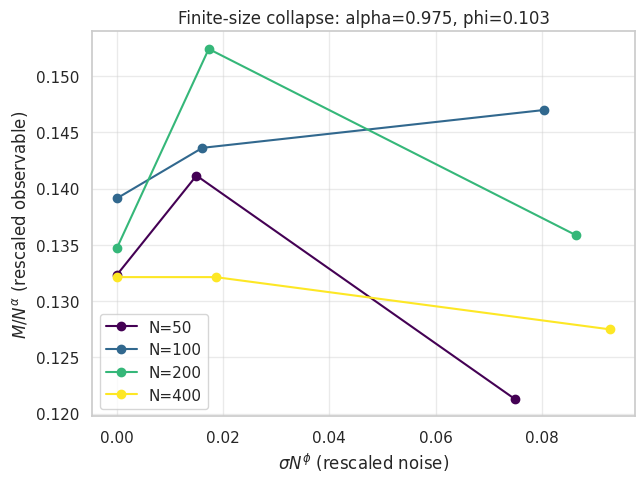

In [17]:
# produce the collapse plot using best2
alpha_opt, phi_opt = best2['alpha'], best2['phi']
X = np.array([[s*(N**phi_opt) for s in sigmas] for N in Ns])
Y = np.array([[M_mat[i,j]/(N**alpha_opt) for j,s in enumerate(sigmas)] for i,N in enumerate(Ns)])

plt.figure(figsize=(7,5))
colors = plt.cm.viridis(np.linspace(0,1,len(Ns)))
for i,N in enumerate(Ns):
    plt.plot(X[i,:], Y[i,:], marker='o', label=f'N={N}', color=colors[i])
plt.xlabel(r'$\sigma N^{\phi}$ (rescaled noise)')
plt.ylabel(r'$M/N^{\alpha}$ (rescaled observable)')
plt.title(f'Finite-size collapse: alpha={alpha_opt:.3f}, phi={phi_opt:.3f}')
plt.legend(); plt.grid(alpha=0.4)
plt.show()


ROBUSTNESS ANALYSIS

In [18]:
import os, time, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams, bottleneck
from sklearn.linear_model import LinearRegression
%matplotlib inline
os.makedirs('results', exist_ok=True)
np.random.seed(42)

# --- samplers (minimal, same as before) ---
def sample_uniform_disk(n, radius=1.0):
    theta = np.random.uniform(0, 2*np.pi, size=n)
    r = np.sqrt(np.random.uniform(0, 1, size=n)) * radius
    x = r * np.cos(theta); y = r * np.sin(theta)
    return np.vstack([x, y]).T

def sample_gaussian(n, scale=1.0):
    return np.random.normal(scale=scale, size=(n, 2))

def sample_circle(n, radius=1.0, noise=0.0):
    theta = np.random.uniform(0, 2*np.pi, size=n)
    x = radius * np.cos(theta); y = radius * np.sin(theta)
    pts = np.vstack([x, y]).T
    if noise > 0:
        pts += np.random.normal(scale=noise, size=pts.shape)
    return pts

# --- persistence helpers ---
def compute_dgms(points, maxdim=1):
    return ripser(points, maxdim=maxdim)['dgms']

def count_long_bars(dgm, persistence_threshold=0.02):
    if dgm.size == 0: return 0
    lifetimes = dgm[:,1] - dgm[:,0]
    lifetimes = lifetimes[np.isfinite(lifetimes)]
    return int(np.sum(lifetimes >= persistence_threshold))

def top_k_count_from_dgm(dgm, k=1):
    if dgm.size == 0: return 0
    lif = dgm[:,1]-dgm[:,0]
    lif = lif[np.isfinite(lif)]
    if len(lif)==0: return 0
    lif_sorted = np.sort(lif)[::-1]
    return min(k, len(lif_sorted))


In [19]:

models = ['disk','gaussian','circle']
Ns = [50,100,200,400]   # expand later to [50,100,200,400,800,1600]
noises = [0.0,0.01,0.05]
R = 8                    # increase to 20 for final
taus = np.logspace(-3, -0.3, 12)  # 0.001 .. ~0.5

# function to run one trial but with custom tau
def single_trial_for_tau(model, N, noise, tau):
    # generate pts
    if model=='disk':
        pts = sample_uniform_disk(N)
        if noise>0: pts += np.random.normal(scale=noise, size=pts.shape)
    elif model=='gaussian':
        pts = sample_gaussian(N)
        if noise>0: pts += np.random.normal(scale=noise, size=pts.shape)
    elif model=='circle':
        pts = sample_circle(N, noise=noise)
    else:
        raise ValueError("unknown model")
    dgms = compute_dgms(pts, maxdim=1)
    long_h1 = count_long_bars(dgms[1], persistence_threshold=tau)
    return long_h1

rows=[]
total = len(models)*len(Ns)*len(noises)*R*len(taus)
i=0; t0=time.time()
for tau in taus:
    for model in models:
        for N in Ns:
            for s in noises:
                vals=[]
                for trial in range(R):
                    i+=1
                    vals.append(single_trial_for_tau(model,N,s,tau))
                    if i%200==0:
                        print(f'progress {i}/{total} elapsed {time.time()-t0:.1f}s')
                rows.append({'tau':tau,'model':model,'N':N,'noise':s,'mean_long_h1':np.mean(vals),'std_long_h1':np.std(vals)})
df_tau = pd.DataFrame(rows)
df_tau.to_csv('results/tau_sweep_results.csv', index=False)
print("Saved results/tau_sweep_results.csv (may take time for larger R/Ns).")


progress 200/3456 elapsed 6.5s
progress 400/3456 elapsed 42.9s
progress 600/3456 elapsed 80.8s
progress 800/3456 elapsed 87.4s
progress 1000/3456 elapsed 123.6s
progress 1200/3456 elapsed 160.4s
progress 1400/3456 elapsed 169.4s
progress 1600/3456 elapsed 202.7s
progress 1800/3456 elapsed 239.5s
progress 2000/3456 elapsed 261.4s
progress 2200/3456 elapsed 284.4s
progress 2400/3456 elapsed 322.3s
progress 2600/3456 elapsed 360.2s
progress 2800/3456 elapsed 366.7s
progress 3000/3456 elapsed 402.3s
progress 3200/3456 elapsed 438.2s
progress 3400/3456 elapsed 446.2s
Saved results/tau_sweep_results.csv (may take time for larger R/Ns).


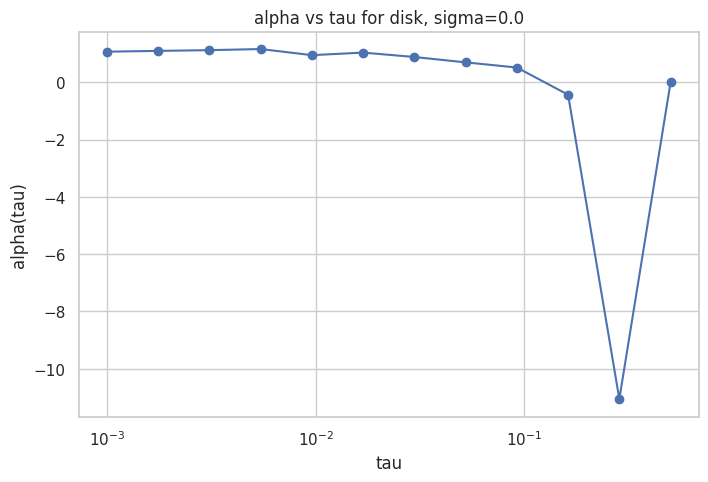

In [20]:
model = 'disk'; sigma0 = 0.0
alphas = []
for tau in sorted(df_tau['tau'].unique()):
    sub = df_tau[(df_tau['tau']==tau)&(df_tau['model']==model)&(df_tau['noise']==sigma0)]
    if len(sub['N'].unique())<3:
        alphas.append(np.nan); continue
    X = np.log(sub['N'].values).reshape(-1,1)
    y = np.log(sub['mean_long_h1'].values + 1e-12)
    lr = LinearRegression().fit(X,y)
    alphas.append(lr.coef_[0])
plt.semilogx(sorted(df_tau['tau'].unique()), alphas, marker='o')
plt.xlabel('tau'); plt.ylabel('alpha(tau)'); plt.title(f'alpha vs tau for {model}, sigma={sigma0}')
plt.grid(True); plt.show()


In [21]:
Ns_full = [50,100,200,400]   # expand later
null_model = 'gaussian'
null_reps = 200   # increase for accuracy (200-1000); reduce to 100 for speed
quantile = 0.95

tau_N = {}
for N in Ns_full:
    lifetimes = []
    for r in range(null_reps):
        pts = sample_gaussian(N)
        dgms = compute_dgms(pts, maxdim=1)
        h1 = dgms[1]
        lif = (h1[:,1] - h1[:,0])
        lif = lif[np.isfinite(lif)]
        if len(lif)>0:
            lifetimes.extend(lif.tolist())
    if len(lifetimes)==0:
        tau_N[N] = 0.0
    else:
        tau_N[N] = float(np.quantile(lifetimes, quantile))
    print(f"N={N} tau_N={tau_N[N]:.4f}")

# Now compute mean_long_h1 using tau_N per N (for each model/noise)
rows = []
for model in models:
    for N in Ns_full:
        tau_here = tau_N[N]
        for s in noises:
            vals=[]
            for trial in range(R):
                # call single_trial_for_tau
                vals.append(single_trial_for_tau(model,N,s,tau_here))
            rows.append({'model':model,'N':N,'noise':s,'tau_N':tau_here,'mean_long_h1_tauN':np.mean(vals),'std':np.std(vals)})
df_adaptive = pd.DataFrame(rows)
df_adaptive.to_csv('results/adaptive_tau_results.csv', index=False)
print("Saved results/adaptive_tau_results.csv")


N=50 tau_N=0.3100
N=100 tau_N=0.2552
N=200 tau_N=0.2108
N=400 tau_N=0.1710
Saved results/adaptive_tau_results.csv


In [22]:
def single_trial_topk(model,N,noise,k=1):
    if model=='disk':
        pts = sample_uniform_disk(N)
        if noise>0: pts += np.random.normal(scale=noise, size=pts.shape)
    elif model=='gaussian':
        pts = sample_gaussian(N)
        if noise>0: pts += np.random.normal(scale=noise, size=pts.shape)
    elif model=='circle':
        pts = sample_circle(N, noise=noise)
    else:
        raise ValueError("unknown model")
    dgms = compute_dgms(pts, maxdim=1)
    topk = top_k_count_from_dgm(dgms[1], k=k)
    return topk

# run for k=1 and compare to fixed-tau counts
rows=[]
k=1
for model in models:
    for N in Ns:
        for s in noises:
            vals=[]
            for t in range(R):
                vals.append(single_trial_topk(model,N,s,k=k))
            rows.append({'model':model,'N':N,'noise':s,'k':k,'mean_topk':np.mean(vals),'std_topk':np.std(vals)})
df_topk = pd.DataFrame(rows)
df_topk.to_csv('results/topk_results.csv', index=False)
print("Saved results/topk_results.csv")


Saved results/topk_results.csv


In [23]:
combos = [
    ('circle',200,0.01),
    ('disk',200,0.01),
    ('gaussian',200,0.01),
]
rows=[]
for model,N,s in combos:
    long1_list = []
    long2_list = []
    for t in range(R):
        # generate same pts for fair comparison? generate separately is fine for robustness
        if model=='circle':
            pts = sample_circle(N, noise=s)
        elif model=='disk':
            pts = sample_uniform_disk(N);
            if s>0: pts += np.random.normal(scale=s, size=pts.shape)
        else:
            pts = sample_gaussian(N)
            if s>0: pts += np.random.normal(scale=s, size=pts.shape)
        dg1 = ripser(pts, maxdim=1)['dgms']
        dg2 = ripser(pts, maxdim=2)['dgms']
        long1_list.append(count_long_bars(dg1[1], persistence_threshold=0.02))
        long2_list.append(count_long_bars(dg2[1], persistence_threshold=0.02))
    rows.append({'model':model,'N':N,'noise':s,'mean_long_h1_maxdim1':np.mean(long1_list),'mean_long_h1_maxdim2':np.mean(long2_list),'std1':np.std(long1_list),'std2':np.std(long2_list)})
df_dim = pd.DataFrame(rows)
df_dim.to_csv('results/maxdim_compare.csv', index=False)
print("Saved results/maxdim_compare.csv — examine differences; if small, maxdim=1 is fine.")
df_dim


Saved results/maxdim_compare.csv — examine differences; if small, maxdim=1 is fine.


,model,N,noise,mean_long_h1_maxdim1,mean_long_h1_maxdim2,std1,std2
0,circle,200,0.01,1.000,1.000,0.000000,0.000000
1,disk,200,0.01,25.375,25.375,2.341874,2.341874
2,gaussian,200,0.01,33.125,33.125,2.712817,2.712817


In [24]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r results /content/drive/MyDrive/tda_results
print("Copied ./results -> /content/drive/MyDrive/tda_results (check Drive).")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied ./results -> /content/drive/MyDrive/tda_results (check Drive).


### Final conclusion

This project empirically investigated the stability and scaling behaviour of Betti numbers in random point clouds using persistent homology. The results demonstrate that while random geometric structures produce proliferating topological noise, true geometric features such as the circle's H₁ class remain robust when appropriate persistence criteria are used. Overall, this study illustrates how topological data analysis connects probabilistic geometry, numerical experimentation, and data-driven inference.
